<a href="https://colab.research.google.com/github/Kranium2002/Bark_Classification/blob/main/Bark_Classification_Hybrid_Model_Resnet%2BXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Kranium2002/Bark_Classification.git

Cloning into 'Bark_Classification'...
remote: Enumerating objects: 5637, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 5637 (delta 4), reused 11 (delta 2), pack-reused 5621
Receiving objects: 100% (5637/5637), 259.03 MiB | 44.25 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard

from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tqdm import tqdm
import cv2 as cv2
from keras.preprocessing.image import img_to_array

In [3]:
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 300
directory_root = '/content/Bark_Classification/BarkVN'
width=256
height=256
depth=3

Data Preprocessing

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
bark_classify_folder_list = os.listdir("/content/Bark_Classification/BarkVN/")
count=0
for folder in bark_classify_folder_list:
        plant_bark_image_list = os.listdir(f"{directory_root}/{folder}/")
        print(plant_bark_image_list)
        count=0
        print(count)

        for image in plant_bark_image_list:
                image_directory = f"{directory_root}/{folder}/{image}"
                if (image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(folder)
                    count+=1

['IMG_3685.JPG', 'IMG_3707.JPG', 'IMG_3704.JPG', 'IMG_3692.JPG', 'IMG_3762.JPG', 'IMG_3699.JPG', 'IMG_3693.JPG', 'IMG_3689.JPG', 'IMG_3687.JPG', 'IMG_3716.JPG', 'IMG_3691.JPG', 'IMG_3756.JPG', 'IMG_3694.JPG', 'IMG_3765.JPG', 'IMG_3696.JPG', 'IMG_3751.JPG', 'IMG_3764.JPG', 'IMG_3720.JPG', 'IMG_3711.JPG', 'IMG_3774.JPG', 'IMG_3729.JPG', 'IMG_3702.JPG', 'IMG_3734.JPG', 'IMG_3706.JPG', 'IMG_3698.JPG', 'IMG_3695.JPG', 'IMG_3723.JPG', 'IMG_3718.JPG', 'IMG_3777.JPG', 'IMG_3745.JPG', 'IMG_3768.JPG', 'IMG_3757.JPG', 'IMG_3754.JPG', 'IMG_3779.JPG', 'IMG_3708.JPG', 'IMG_3733.JPG', 'IMG_3736.JPG', 'IMG_3772.JPG', 'IMG_3728.JPG', 'IMG_3780.JPG', 'IMG_3760.JPG', 'IMG_3727.JPG', 'IMG_3759.JPG', 'IMG_3771.JPG', 'IMG_3713.JPG', 'IMG_3735.JPG', 'IMG_3748.JPG', 'IMG_3703.JPG', 'IMG_3738.JPG', 'IMG_3725.JPG', 'IMG_3746.JPG', 'IMG_3778.JPG', 'IMG_3781.JPG', 'IMG_3750.JPG', 'IMG_3722.JPG', 'IMG_3761.JPG', 'IMG_3753.JPG', 'IMG_3741.JPG', 'IMG_3712.JPG', 'IMG_3731.JPG', 'IMG_3737.JPG', 'IMG_3773.JPG', 'IMG_37

In [6]:
len(label_list)

5578

In [7]:
np_image_list = np.array(image_list, dtype=np.float16)
print(len(np_image_list))

5578


Label Encoding


In [8]:
le = preprocessing.LabelEncoder()
le.fit(label_list)

y=le.transform(label_list)

Train Test Split

In [9]:

print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list,y, test_size=0.4, random_state = 64)

[INFO] Spliting data to train, test


In [10]:
x_train.shape

(3346, 256, 256, 3)

In [11]:
#Deleting unused variables for memory optimization
del(le)
del(plant_bark_image_list)
del(label_list)
del(image_list)
del(np_image_list)
del(y)

Basic Data Argumentation to increase the generalization of models

In [12]:

def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    
    return data_augmentation

Base Resnet50 Model

In [13]:
def bark_model(model_input: Tensor, data_augmentation=data_augmenter()):

    
    
    
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(256,256,3),
                                                   include_top=False, 
                                                   weights='imagenet',input_tensor=model_input) 
    

    base_model.trainable = False
   
    data_augmentation = data_augmenter()
   
    x = data_augmentation(model_input)
   
    x = tf.keras.applications.resnet50.preprocess_input(x) 
    
   
    x = base_model(x, training=False) 
    
   
   
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
   
    x = tf.keras.layers.Dropout(0.2)(x)
        
   
    x = tf.keras.layers.Dense(50)(x)
    
  
    
    model = Model(model_input, x, name='model')
    
    return model

In [14]:
input_shape = (256,256,3)
print(input_shape)
model_input = Input(shape=input_shape)
print(model_input)

(256, 256, 3)
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [15]:
model = bark_model(model_input, data_augmenter())

for layer in model.layers:
  print(layer)

In [16]:

model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Training Resnet with last layer as a Softmax layer

In [17]:
history = model.fit(x_train,y_train,validation_split=0.3,epochs=10)

Epoch 1/10
98/98 [==============================] - 44s 255ms/step - loss: 1.8529 - accuracy: 0.5556 - val_loss: 0.7713 - val_accuracy: 0.8148
Epoch 2/10
98/98 [==============================] - 20s 201ms/step - loss: 0.5873 - accuracy: 0.8598 - val_loss: 0.5026 - val_accuracy: 0.8827
Epoch 3/10
98/98 [==============================] - 20s 206ms/step - loss: 0.3766 - accuracy: 0.9151 - val_loss: 0.3692 - val_accuracy: 0.9037
Epoch 4/10
98/98 [==============================] - 20s 207ms/step - loss: 0.2796 - accuracy: 0.9344 - val_loss: 0.2914 - val_accuracy: 0.9350
Epoch 5/10
98/98 [==============================] - 20s 205ms/step - loss: 0.2206 - accuracy: 0.9545 - val_loss: 0.2462 - val_accuracy: 0.9432
Epoch 6/10
98/98 [==============================] - 20s 206ms/step - loss: 0.1859 - accuracy: 0.9549 - val_loss: 0.2497 - val_accuracy: 0.9388
Epoch 7/10
98/98 [==============================] - 20s 203ms/step - loss: 0.1568 - accuracy: 0.9664 - val_loss: 0.2232 - val_accuracy: 0.9440

Result of Transfer Training with Resnet50


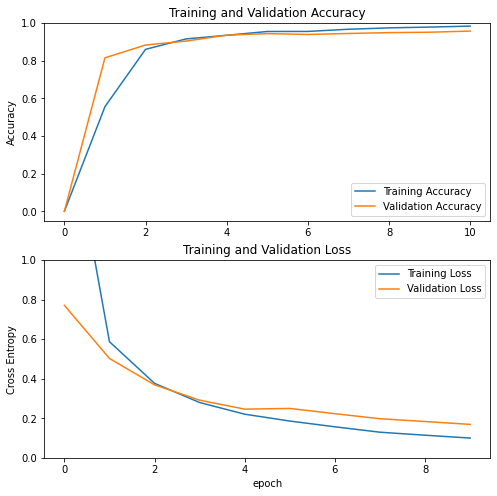

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
#For training 

model.save('model')

In [12]:
#For training 


model = tf.keras.models.load_model('/content/Bark_Classification/model.h5')

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

Making an intermediate layer model from resnet to use for feature selection 

In [14]:
from keras.models import Model
layer_name='global_average_pooling2d'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [15]:
#Deleting base model for memory optimization

del(model)


In [16]:
import pandas as pd

In [17]:

intermediate_output = intermediate_layer_model.predict(x_test) 
intermediate_output = pd.DataFrame(data=intermediate_output)

In [18]:
intermediate_output.shape

(2232, 2048)

In [19]:

intermediate_output_train = intermediate_layer_model.predict(x_train) 
intermediate_output_train = pd.DataFrame(data=intermediate_output_train)

In [20]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
intermediate_output_train.shape

(3346, 2048)

In [22]:
y_train.shape

(3346,)

In [23]:
del(intermediate_layer_model)


Starting to make hybrid models using XGBoost

In [29]:
from xgboost import XGBClassifier

In [23]:


xgbmodel = XGBClassifier(objective='multi:softprob', 
                      num_class= 50)


Parameter Search for XGBoost

In [24]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [26]:
#Parameter Search for XGBoost
from sklearn.metrics import roc_auc_score
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgbmodel, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(intermediate_output_train, y_train), verbose=3, random_state=1001 )


random_search.fit(intermediate_output_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f0d25ccc850>,
                   estimator=XGBClassifier(num_class=50,
                                           objective='multi:softprob'),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [27]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([2508.58811148, 2179.66993221, 1544.35972055, 1739.05803943,
       2090.7671864 ]), 'std_fit_time': array([  4.33956484,   3.69749309,  23.72980562,   3.55487689,
       125.69129795]), 'mean_score_time': array([0.00134524, 0.00085052, 0.00297729, 0.00047191, 0.00053962]), 'std_score_time': array([6.58568720e-05, 4.48836187e-04, 3.34329422e-03, 2.56949410e-05,
       8.22559839e-05]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, 

Results of Conv XGBoost hybrid model

In [42]:
xgb=XGBClassifier(colsample_bytree=1,num_class=50,
       gamma=5, max_depth=3,
       min_child_weight=5,n_estimators=100,
       objective='multi:softprob', subsample=1)

In [ ]:
xgb.fit(intermediate_output_train,y_train)

In [ ]:
xgb.score(intermediate_output, y_test)

In [ ]:
tf.keras.utils.plot_model(xgb)